## TauRunner

Welcome to the TauRunner tutorial! This software is capable of simulating neutrinos (and anti-neutrinos) of all flavors, accounting for tau regeneration and losses in the nutau channel. The output is a set of particle energies, number of interactions, angle, and particle type.

The user has the option to propagate:
1. monochromatic fluxes
2. power-law fluxes
3. Any provided arbitrary flux by means of sampling from a cdf. 

All of these can be propagated through either:
1. a fixed angle
2. a range of angles
3. uniformly sampled angles in the sky. 

In terms of astrophysical bodies, we provide implementations for the Earth and Sun with capabilities of adding additional layers and changing the detector depth. In addition, we will demonstrate how to define any astrophysical object, or a slab of constant density to propagate through. All of these capabilities will be shown in the following examples. Happy running!

## Example 1: Monochromatic flux through single angle in Earth ##

The main function that runs the monte carlo is called `run_MC` and required a few arguments, which we show you how to create below
* `energies`: An array of initial particle energies in eV
* `thetas`: A corresponding array of initial nadir angles in radians
* `body`: The body which we are propagating through (Earth, Sun, custom, etc.)
* `xs`: a CrossSections object which is based on a certain cross section model
* `propagator`: PROPOSAL propagator object for charged lepton propagation

In [4]:
import numpy as np

from taurunner.main import run_MC
from taurunner.body.earth import construct_earth
from taurunner.cross_sections import CrossSections
from taurunner.utils import make_propagator, make_initial_e, make_initial_thetas

nevents  = 5000 # number of events to simulate
eini     = 1e19 # initial energy in GeV
theta    = 89.0 # incidence angle (nadir)
pid      = 16 # PDG MC Encoding particle ID (nutau)
xs_model = "CSMS" # neutrino cross section model 

Earth    = construct_earth(layers=[(4., 1.0)]) # Make Earth object with 4km water layer
xs       = CrossSections(xs_model)
energies = make_initial_e(nevents, eini) # Return array of initial energies in eV
thetas   = make_initial_thetas(nevents, theta)

tau_prop = make_propagator(pid, Earth)
rand     = np.random.RandomState(seed=7)

output = run_MC(energies, 
                thetas, 
                Earth, 
                xs,
                tau_prop, 
                rand,
         )

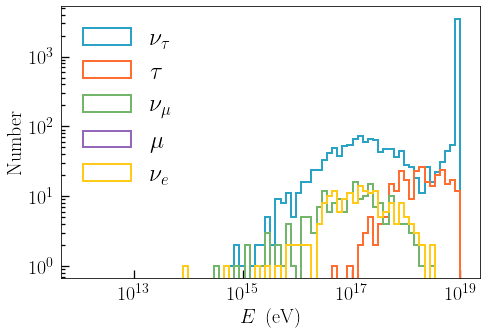

In [5]:
import matplotlib.pyplot as plt
plt.style.use('../paper.mplstyle')

pid_names = {
    11: 'r$e$', 
    12: r'$\nu_{e}$', 
    13: r'$\mu$', 
    14: r'$\nu_{\mu}$',
    15: r'$\tau$',
    16: r'$\nu_{\tau}$'
}

bins  = np.logspace(12, 19, 75)
zeros = output['Eout']==0.

for pid in reversed(range(12,17)):
    particle_msk = np.logical_and(np.abs(output['PDG_Encoding'])==pid, ~zeros)
    name = pid_names[pid]
    plt.hist(output['Eout'][particle_msk], bins=bins, label=name,
            lw=2., histtype='step')
    
plt.legend(frameon=False, loc=2)
plt.loglog()
plt.xlabel(r'$E~\left(\rm{eV}\right)$')
plt.ylabel('Number')
plt.show()

## Example 2: Power law flux

`taurunner` also provides helper functions to propagate other spectral shapes, such as power laws or pre-loaded models of cosmogenic neutrinos

In [12]:
import numpy as np

from taurunner.main import run_MC
from taurunner.body.earth import construct_earth
from taurunner.cross_sections import CrossSections
from taurunner.utils import make_propagator, make_initial_e, make_initial_thetas

nevents        = 10 # number of events to simulate  
pid            = 16
xs_model       = "CSMS"
no_secondaries = True

Earth = construct_earth(layers=[(4., 1.0)])
xs    = CrossSections(xs_model)
rand  = np.random.RandomState(seed=7)

# Sample power-law with index -2 between 1e6 GeV and 1e12 GeV
pl_exp   = -2 # power law exponent
e_min    = 1e6 # Minimum energy to sample in GeV
e_max    = 1e12 # Maximum energy to sample in GeV
energies = make_initial_e(nevents,
                          pl_exp, 
                          e_min=1e15, 
                          e_max=1e21, 
                          rand=rand
                         )

# Sample uniform in solid angle over hemisphere                    
th_min = 0 # Minimum nadir angle to sample from
th_max = 90 # Maximum nadir angle to sample from
thetas = make_initial_thetas(nevents, 
                             (th_min, th_max), 
                             rand=rand
                            )

# tracks   = make_tracks(thetas)
tau_prop = make_propagator(pid, Earth)


output = run_MC(energies, 
                thetas, 
                Earth, 
                xs, 
                tau_prop, 
                rand,
                no_secondaries=no_secondaries
               )

Here, we are choosing to propagate an $E^{-2}$ spectrum over an entire hemisphere. 
There are some additional keyword arguments that allow the user to turn off tau energy losses (which are less important for more steeply inclined angles) or ignore secondary particles

In [13]:
output

array([(1.08261220e+15, 5.89531024e+14, 71.29050216, 0, 1, 16, 0, 1.),
       (4.54376122e+15, 4.18573281e+14, 78.68160499, 2, 0, 16, 1, 1.),
       (1.78065466e+15, 2.01561186e+14, 51.75255953, 2, 0, 16, 2, 1.),
       (3.61617165e+15, 2.58058249e+10, 20.92260565, 3, 1, 16, 3, 1.),
       (4.54308677e+16, 1.02253292e+15, 44.61400454, 2, 2, 16, 4, 1.),
       (2.16682532e+15, 2.16682532e+15, 84.81300843, 0, 0, 16, 5, 1.),
       (2.00448991e+15, 1.78378703e+14, 38.1297391 , 1, 0, 16, 6, 1.),
       (1.07764550e+15, 2.52171698e+14, 56.77857801, 1, 0, 16, 7, 1.),
       (1.36693947e+15, 1.36693947e+15, 86.05527962, 0, 0, 16, 8, 1.),
       (1.99952812e+15, 7.81343307e+14, 12.81255794, 1, 3, 16, 9, 1.)],
      dtype=[('Eini', '<f8'), ('Eout', '<f8'), ('Theta', '<f8'), ('nCC', '<i8'), ('nNC', '<i8'), ('PDG_Encoding', '<i8'), ('primary_tau', '<i8'), ('final_position', '<f8')])

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('../paper.mplstyle')
from matplotlib.colors import LogNorm

bins  = np.logspace(12, 19, 75)
zeros = output['Eout']==0.
nutau_msk = np.logical_and(np.abs(output['PDG_Encoding'])==16, ~zeros)
plt.hist2d(
    output['Eini'][nutau_msk], 
    np.cos(np.radians(output['Theta'][nutau_msk])), 
    bins=[np.logspace(12., 17., 21), 
          np.linspace(0., 1., 21)],
    norm=LogNorm()
)

plt.xscale('log')
plt.xlabel(r'$E_{\rm{initial}}~(\rm{eV})$')
plt.ylabel(r'$\cos(\theta)$')
plt.title("Initial Energy Distribution")
plt.show()

In [ ]:
from matplotlib.colors import LogNorm

bins  = np.logspace(12, 19, 75)
zeros = output['Eout']==0.
nutau_msk = np.logical_and(np.abs(output['PDG_Encoding'])==16, ~zeros)
plt.hist2d(
    output['Eout'][nutau_msk], 
    np.cos(np.radians(output['Theta'][nutau_msk])), 
    bins=[np.logspace(12., 17., 21), 
          np.linspace(0., 1., 21)],
    norm=LogNorm()
)

plt.xscale('log')
plt.xlabel(r'$E_{\rm{final}}~(\rm{eV})$')
plt.ylabel(r'$\cos(\theta)$')
plt.title("Final Energy Distribution")
plt.show()

Here, it is evident that the neutrinos that were propagated through more Earth (larger $\cos(\theta)$) exit the Earth at much lower energies than the neutrinos that were able to pass through skimming trajectories undergoing few, if any, interactions

We can also look at the one-dimensional energy spectra

In [ ]:
zeros = output['Eout']==0.

for pid in reversed(range(12,17)):
    particle_msk = np.logical_and(np.abs(output['PDG_Encoding'])==pid, ~zeros)
    name = pid_names[pid]
    plt.hist(output['Eout'][particle_msk], bins=bins, label=name,
             lw=2., histtype='step')
    
plt.legend(frameon=False, loc=1)
plt.loglog()
plt.xlabel(r'$E$ (eV)')
plt.ylabel('Number')
plt.show()

Notice how there are only tau neutrinos because we chose to not propagate any secondary particles. 

## Example 3: Propagating a custom flux through Earth

`taurunner` allows the user to supply CDFs in energy to be samlped from. Here we show an example of sampling from a GZK model. An example of how to create these CDFs is given in `make_flux_CDF.ipynb`

In [9]:
import numpy as np

import taurunner as tr
from taurunner.main import run_MC
from taurunner.body.earth import construct_earth
from taurunner.cross_sections import CrossSections
from taurunner.utils import make_propagator, make_initial_e, make_initial_thetas

nevents  = 5000
pid      = 16
xs_model = "CSMS"

Earth    = construct_earth(layers=[(4., 1.0)])
xs       = CrossSections(xs_model)

tau_prop = make_propagator(pid, Earth)
rand     = np.random.RandomState(seed=7)

# Sample from pickled CDF
pkl_f    = f'{tr.__path__[0]}/resources/ahlers2010_' # Path to pickle file with CDF to sample from
energies = make_initial_e(nevents,
                          pkl_f, 
                          rand=rand
)
                         
# Sample uniform in solid angle over hemisphere   
th_min = 0 # Minimum nadir angle to sample from
th_max = 90 # Maximum nadir angle to sample from  
thetas = make_initial_thetas(nevents, 
                             (th_min, th_max), 
                             rand=rand
)

output = run_MC(energies, 
                thetas, 
                Earth, 
                xs, 
                tau_prop, 
                rand
)

10
10


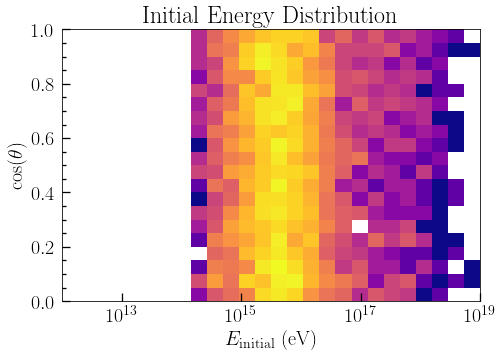

In [10]:
import matplotlib.pyplot as plt
plt.style.use('../paper.mplstyle')
from matplotlib.colors import LogNorm

bins  = np.logspace(12, 19, 75)
zeros = output['Eout']==0.
nutau_msk = np.logical_and(np.abs(output['PDG_Encoding'])==16, ~zeros)
plt.hist2d(
    output['Eini'][nutau_msk], 
    np.cos(np.radians(output['Theta'][nutau_msk])), 
    bins=[np.logspace(12., 19., 27), 
          np.linspace(0., 1., 21)],
    norm=LogNorm()
)

plt.xscale('log')
plt.xlabel(r'$E_{\rm{initial}}$ (eV)')
plt.ylabel(r'$\cos(\theta)$')
plt.title("Initial Energy Distribution")
plt.show()

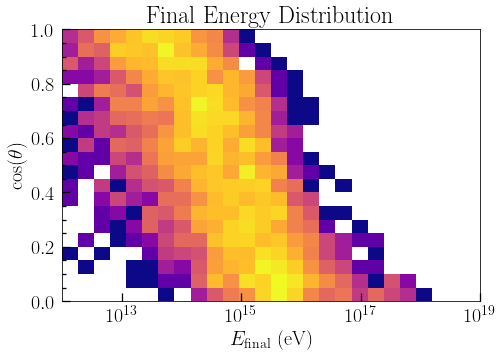

In [11]:
from matplotlib.colors import LogNorm

bins  = np.logspace(12, 19, 75)
zeros = output['Eout']==0.
nutau_msk = np.logical_and(np.abs(output['PDG_Encoding'])==16, ~zeros)
plt.hist2d(
    output['Eout'][nutau_msk], 
    np.cos(np.radians(output['Theta'][nutau_msk])), 
    bins=[np.logspace(12., 19., 27), 
          np.linspace(0., 1., 21)],
    norm=LogNorm()
)

plt.xscale('log')
plt.xlabel(r'$E_{\rm{final}}$ (eV)')
plt.ylabel(r'$\cos(\theta)$')
plt.title("Final Energy Distribution")
plt.show()

## Example 4: Radial trajectories

TauRunner supports custom trajectories besides chords. TauRunner includes a radial trajectory which moves radially outward from the center of the body

In [23]:
import numpy as np

from taurunner.main import run_MC
from taurunner.body.earth import construct_earth
from taurunner.cross_sections import CrossSections
from taurunner.utils import make_propagator, make_initial_e

nevents  = 5000
eini     = 1e10
pid      = 16
xs_model = "CSMS"

Earth    = construct_earth(layers=[(4., 1.0)]) # Make Earth object with 4km water layer
xs       = CrossSections(xs_model)
energies = make_initial_e(nevents, eini)
thetas   = np.zeros(nevents)

tau_prop = make_propagator(pid, Earth)
rand     = np.random.RandomState(seed=7)

output = run_MC(energies, 
                thetas,
                Earth, 
                xs, 
                tau_prop, 
                rand,
)

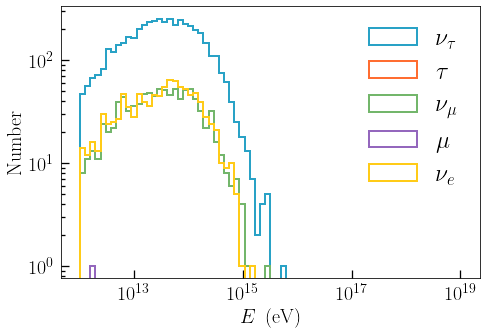

In [24]:
import matplotlib.pyplot as plt
plt.style.use('../paper.mplstyle')

pid_names = {
    11: 'r$e$', 
    12: r'$\nu_{e}$', 
    13: r'$\mu$', 
    14: r'$\nu_{\mu}$',
    15: r'$\tau$',
    16: r'$\nu_{\tau}$'
}

bins  = np.logspace(12, 19, 75)
zeros = output['Eout']==0.

for pid in reversed(range(12,17)):
    particle_msk = np.logical_and(np.abs(output['PDG_Encoding'])==pid, ~zeros)
    name = pid_names[pid]
    plt.hist(output['Eout'][particle_msk], bins=bins, label=name,
            lw=2., histtype='step')
    
plt.legend(frameon=False, loc=1)
plt.loglog()
plt.xlabel(r'$E~\left(\rm{eV}\right)$')
plt.ylabel('Number')
plt.show()

## Example 4: Propagating through other bodies

In addition to propagating neutrinos through the Earth, you can also propagate neutrinos through the Sun or through any object given a density profile

In [12]:
from taurunner.body import construct_sun
from taurunner.body import Body

### First, through the Sun

In [21]:
import numpy as np
from taurunner.main import run_MC
from taurunner.body import construct_sun
from taurunner.cross_sections import CrossSections
from taurunner.utils import make_propagator, make_initial_e, make_initial_thetas

nevents     = 1000
eini        = 1e4 # the sun is opaque at high energies
theta       = 10.0
pid         = 16
xs_model    = "dipole"
solar_model = "HZ_Sun" # Can also be "LZ_Sun"
                                   
xs       = CrossSections(xs_model)
energies = make_initial_e(nevents, eini)
thetas   = make_initial_thetas(nevents, theta)

sun      = construct_sun(solar_model)
tau_prop = make_propagator(pid, sun, granularity=0.5) 
rand     = np.random.RandomState(seed=7)

output = run_MC(energies, 
                thetas, 
                sun, 
                xs, 
                tau_prop, 
                rand
)

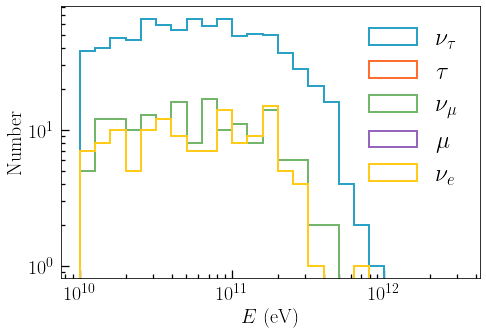

In [20]:
import matplotlib.pyplot as plt
plt.style.use('../paper.mplstyle')

bins  = np.logspace(10, 12.5, 26)
zeros = output['Eout']==0.

pid_names = {
    11: 'r$e$', 
    12: r'$\nu_{e}$', 
    13: r'$\mu$', 
    14: r'$\nu_{\mu}$',
    15: r'$\tau$',
    16: r'$\nu_{\tau}$'
}


for pid in reversed(range(12,17)):
    particle_msk = np.logical_and(np.abs(output['PDG_Encoding'])==pid, ~zeros)
    name = pid_names[pid]
    plt.hist(output['Eout'][particle_msk], bins=bins, label=name,
            lw=2., histtype='step')
    
plt.legend(frameon=False, loc=1)
plt.loglog()
plt.xlabel(r'$E$ (eV)')
plt.ylabel('Number')
plt.show()

### And next, through a slab of constant density which we construct using the `Body` object and a radial trajectory

In [3]:
import numpy as np

from taurunner.body import Body
from taurunner.main import run_MC
from taurunner.cross_sections import CrossSections
from taurunner.utils import make_propagator, make_initial_e, make_initial_thetas

nevents  = 5000
eini     = 1e10
theta    = 0
pid      = 16
xs_model = "CSMS"

# Make body with density 3.14 g/cm^3 and radius 1000 km
body     = Body(3.14, 1e3)

xs       = CrossSections(xs_model)
energies = make_initial_e(nevents, eini)
thetas   = make_initial_thetas(nevents, theta)

tau_prop = make_propagator(pid, body)
rand     = np.random.RandomState(seed=7)

output   = run_MC(energies, 
                  thetas, 
                  body, 
                  xs, 
                  tau_prop, 
                  rand
)

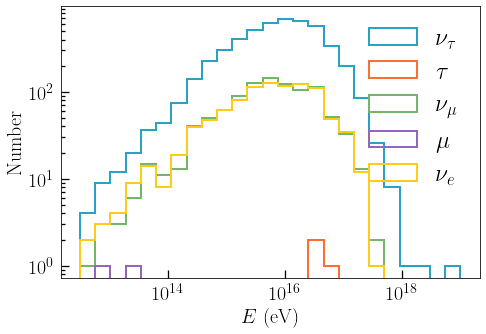

In [4]:
import matplotlib.pyplot as plt
plt.style.use('../paper.mplstyle')

bins  = np.logspace(12.5, 19, 26)
zeros = output['Eout']==0.

pid_names = {
    11: 'r$e$', 
    12: r'$\nu_{e}$', 
    13: r'$\mu$', 
    14: r'$\nu_{\mu}$',
    15: r'$\tau$',
    16: r'$\nu_{\tau}$'
}

for pid in reversed(range(12,17)):
    particle_msk = np.logical_and(np.abs(output['PDG_Encoding'])==pid, ~zeros)
    name = pid_names[pid]
    plt.hist(output['Eout'][particle_msk], bins=bins, label=name,
            lw=2., histtype='step')
    
plt.legend(frameon=False, loc=1)
plt.loglog()
plt.xlabel(r'$E$ (eV)')
plt.ylabel('Number')
plt.show()

### And next, through a layered slab

The constant density slab may be generalized to a slab of multiple layers. The densities in each layer may be positive scalars, unary functions which return positive scalars, or a potentially mixed list of such objects. In this example, we show how to accomplish this latter option.

In [5]:
import numpy as np

from taurunner.body import Body
from taurunner.main import run_MC
from taurunner.cross_sections import CrossSections
from taurunner.utils import make_propagator, make_initial_e, make_initial_thetas

nevents  = 1000
eini     = 1e7
theta    = 0
pid      = 16
xs_model = "CSMS"

# Make layered body with radius 1,000 km
def middle_density(x):
    return x**-2
densities  = [16, middle_density, 1.78]
boundaries = [0.25, 0.75, 1] # Right hand boundaries of the layers
body = Body([(d, b) for d, b in zip(densities, boundaries)], 1e3)

xs       = CrossSections(xs_model)
energies = make_initial_e(nevents, eini)
thetas   = make_initial_thetas(nevents, theta)

tau_prop = make_propagator(pid, body)
rand     = np.random.RandomState(seed=7)

output = run_MC(energies, 
                thetas, 
                body, 
                xs, 
                tau_prop, 
                rand
)

0.40751363673860397
0.06918644208291146
0.2979368613360152
0.7478023140124742


IndexError: list index out of range

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('../paper.mplstyle')

bins  = np.logspace(12.5, 19, 26)
zeros = output['Eout']==0.

pid_names = {
    11: 'r$e$', 
    12: r'$\nu_{e}$', 
    13: r'$\mu$', 
    14: r'$\nu_{\mu}$',
    15: r'$\tau$',
    16: r'$\nu_{\tau}$'
}


for pid in reversed(range(12,17)):
    particle_msk = np.logical_and(np.abs(output['PDG_Encoding'])==pid, ~zeros)
    name = pid_names[pid]
    plt.hist(output['Eout'][particle_msk], bins=bins, label=name,
            lw=2., histtype='step')
    
plt.legend(frameon=False, loc=1)
plt.loglog()
plt.xlabel(r'$E$ (eV)')
plt.ylabel('Number')
plt.show()

## Example 4: Running from the command line

As is described more thoroughly in the `README`, `taurunner` can also be called from the command line, an example of which is shown inline below

In [25]:
!python ../taurunner/main.py -n 20 -t 0.0 -e 1e9

╒═════════════╤═════════════╤═════════╤═══════╤═══════╤════════════════╕
│        Eini │        Eout │   Theta │   nCC │   nNC │   PDG_Encoding │
╞═════════════╪═════════════╪═════════╪═══════╪═══════╪════════════════╡
│ 1e+18       │ 2.63247e+13 │       0 │     4 │     2 │             16 │
├─────────────┼─────────────┼─────────┼───────┼───────┼────────────────┤
│ 1e+18       │ 2.64058e+13 │       0 │     3 │     1 │             16 │
├─────────────┼─────────────┼─────────┼───────┼───────┼────────────────┤
│ 1e+18       │ 4.0619e+14  │       0 │     5 │     2 │             16 │
├─────────────┼─────────────┼─────────┼───────┼───────┼────────────────┤
│ 1e+18       │ 1.23462e+13 │       0 │     6 │     0 │             16 │
├─────────────┼─────────────┼─────────┼───────┼───────┼────────────────┤
│ 1e+18       │ 1.91583e+14 │       0 │     4 │     3 │             16 │
├─────────────┼─────────────┼─────────┼───────┼───────┼────────────────┤
│ 1e+18       │ 2.13525e+13 │       0 │     5 │    